In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import re
import pandas as pd
import collections
from PIL import Image

In [61]:
# Build a Directed Graph
# https://stackoverflow.com/questions/45460653/given-a-flat-list-of-parent-child-create-a-hierarchical-dictionary-tree
def get_collection_members(df, collection_tree, collection, collectionCSVNamesToName):   
    children = []
    regex = r"^info:fedora/(.*):(.*)$"
    is_collection_member =  df['isMemberOfCollection'] == collection
    member_list = df[is_collection_member]
        
    ## Loop through each member, if it is a collection model, then call this again!
    for index, row in member_list.iterrows():
        pid = row["PID"]
        cmodel = row["cmodel"]
        child = {}
        if cmodel == "info:fedora/islandora:collectionCModel":
            child["name"] = pid
            child["parent"] = collection
            fullPID = "info:fedora/"+pid
            collection_tree = get_collection_members(df, collection_tree, fullPID, collectionCSVNamesToName)
            if collection not in collectionCSVNamesToName:
                collection_name = re.search(regex, collection).group(1).capitalize()+" "+re.search(regex, collection).group(2)
            else:
                collection_name = collectionCSVNamesToName[collection]
            if fullPID not in collectionCSVNamesToName:
                print(fullPID)
                fullPIDName = re.search(regex, fullPID).group(1).capitalize()+" "+re.search(regex, fullPID).group(2)
                collectionCSVNamesToName[fullPID] = fullPIDName
            else:
                fullPIDName = collectionCSVNamesToName[fullPID]
            tup2 = (collection_name, fullPIDName);
            collection_tree.append(tup2)
        
    return collection_tree


In [54]:
def OrderTreeByDepth(tree, depth = 0, dictByDepth = {}, parent = None):
    i = 0
    newDepth = depth + 1
    if tree != {}:
        dictByDepth[newDepth] = {}
    for key in tree.keys():
        if parent != None:
            coords = dictByDepth[depth][parent]
        else:
            coords = []
        dictByDepth[newDepth][key] = coords[:]
        dictByDepth[newDepth][key].append(i)
        dictByDepth = OrderTreeByDepth(tree[key], newDepth, dictByDepth, key)
        i+=1
    return dictByDepth

def GetNodesWithNoChildren(tree, parent = None, noChildren = []):
    if tree == {}:
        noChildren.append(parent)
    else:
        for key in tree.keys():
            noChildren = GetNodesWithNoChildren(tree[key], key, noChildren)
    return noChildren

In [55]:
# Adds the node and the name of the node with position and orientation
def DefineNode(nodeName, nodeX, nodeY, G, pos):
    textOffset = 0.02
    G.add_node(nodeName)
    pos[nodeName] = (nodeX, nodeY)
    plt.text(nodeX+textOffset,nodeY,s=nodeName, horizontalalignment='center',verticalalignment='center', rotation = 'vertical')

# Creates 2 pictures of the tree, one in correct orientation and one of them flipped and saves them in this file's location
def CreateTree(tree):
    plt.figure(figsize = (17,13), dpi = 100)
    G=nx.Graph()
    x = 0
    y = 0
    for root in tree.keys():
        pos = {}
        DefineNode(root, x, y, G, pos)
        BuildTree(G, tree[root], root, pos)
    nx.draw(G, pos = pos, node_size = 300)
    plt.savefig('treeTest.png')
    img = Image.open("treeTest.png")
    rotated = img.transpose(Image.ROTATE_270)
    rotated.save('treeTestTranspose.png')

# Recursively builds the graph
def BuildTree(G, tree, parent, pos, spaceX = 2):
    spaceY = -1
    #pastParent = False
    #for node in tree.keys():
    #    if node != parent:
    increment = spaceX/(len(tree.keys()))
    startX = pos[parent][0]-spaceX/2+increment/2
    startY = pos[parent][1] + spaceY
    i = 0
    for node in tree.keys():
        DefineNode(node, startX+increment*i, startY, G, pos)
        G.add_edge(parent, node)
        if tree[node] != {}:
            G = BuildTree(G, tree[node], node, pos, increment)
        i+=1
    return G

In [56]:
# Creates a tree in a dictionary style with the hierarchy preserved
def ConstructTreeDict(df, collectionCSVNamesToName):
    tree = lambda: collections.defaultdict(tree)
    collection_tree = tree()
    collection = "info:fedora/dsu:root"
    path_list = ["root"]
    collection_tree =[]
    ## Build child parent tuple tree, recursively
    collection_tree = get_collection_members(df, collection_tree, collection, collectionCSVNamesToName)
    lst = collection_tree

    # Build a directed graph and a list of all names that have no parent
    graph = {name: set() for tup in lst for name in tup}
    has_parent = {name: False for tup in lst for name in tup}
    for parent, child in lst:
        graph[parent].add(child)
        has_parent[child] = True

    # All names that have absolutely no parent:
    roots = [name for name, parents in has_parent.items() if not parents]

    # traversal of the graph (doesn't care about duplicates and cycles)
    treeData = []
    def traverse(hierarchy, graph, names):
        for name in names:
            hierarchy[name] = traverse({}, graph, graph[name])
        return hierarchy
    return traverse({}, graph, roots)

{'Digital Scholarship Unit Root Collection': {'Scarborough Data Collection': {}, 'Gunda Gunde Collection': {}, 'UTSC Photoservices': {'Ken Jones Collection': {}}, 'DSU Library Collection': {}, 'Menus Collections': {'Harley Spiller Collection': {'Harley Spiller QA Collection': {'harleyspiller MetadataReview8': {}, 'harleyspiller MetadataReview6': {}, 'harleyspiller MetadataReview9': {}, 'harleyspiller MetadataReview7': {}}}, 'robertbonlee collection': {}}, 'Tamil Collections': {'Brenda Beck Collections': {'Brenda Beck Media': {}}, 'Digital Tamil Studies Collection': {}}, 'Library Workshop Collection': {}, 'UTSC Legacy Archives Collection': {}, 'Doris McCarthy Collection': {}, 'Animal Empire Collection': {}, 'Ottoman Empire Collection': {}, 'Scarborough Oral Histories Collection': {'Nearby Studies Collection': {}}}}
['Scarborough Data Collection', 'Gunda Gunde Collection', 'Ken Jones Collection', 'DSU Library Collection', 'harleyspiller MetadataReview8', 'harleyspiller MetadataReview6', 

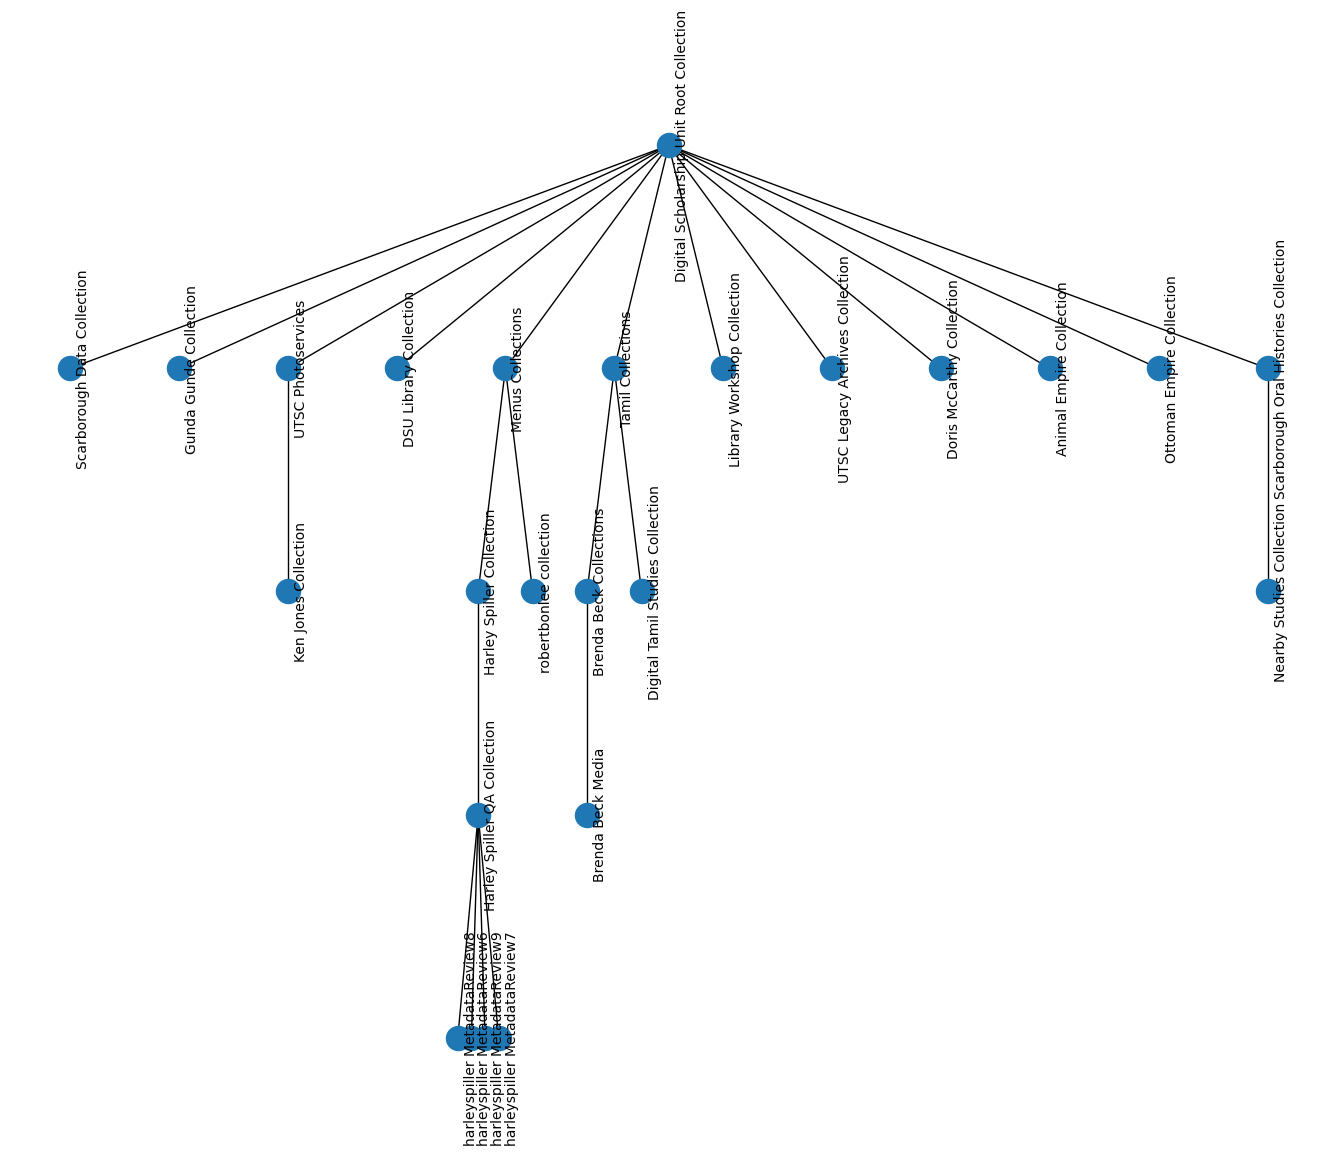

In [57]:
"""df = df = pd.read_csv("data/repo_data_7_july_2020.csv")
collectionCSVNamesToName = {"info:fedora/photoservices:root":"UTSC Photoservices",
"info:fedora/tamil:beckvideos":"Brenda Beck Media",
"info:fedora/utschidden:archives":"Hidden UTSC Archives",
"info:fedora/ottomanempire:collection":"Ottoman Empire Collection",
"info:fedora/hogarth:test201711":"Hogarth Test Collection",
"info:fedora/dsu:library":"DSU Library Collection",
"info:fedora/linc:65e81fe3-bb72-4079-819e-2da0b6b96778":"LINC collection",
"info:fedora/hogarth:harlots":"Hogarth Harlots Progress",
"info:fedora/nearbystudies:collection":"Scarborough Oral Histories Collection",
"info:fedora/hogarth:fourtimesday":"Hogarth Times of Day",
"info:fedora/tamil:beck":"Brenda Beck Collections",
"info:fedora/harleyspiller:newyorkqueenscountybqa":"QA Harley Spiller",
"info:fedora/doris:collection":"Doris McCarthy Collection",
"info:fedora/hogarth:stages":"Hogarth Stages",
"info:fedora/hogarth:marriage":"Hogarth Marriage",
"info:fedora/hogarth:hpic":"Hogarth Root Collection",
"info:fedora/islandora:root":"Islandora Root Collection",
"info:fedora/animalempire:root":"Animal Empire Collection",
"info:fedora/dsu:scarborough-data":"Scarborough Data Collection",
"info:fedora/dsu:workshops":"Library Workshop Collection",
"info:fedora/hogarth:rakesprogress":"Hogarth Rake's Progress",
"info:fedora/hogarth:root":"Hogarth Root Collection",
"info:fedora/harleyspiller:collection":"Harley Spiller Collection",
"info:fedora/harleyspiller:englandqa":"Harley Spiller QA Collection",
"info:fedora/nearbystudies:931":"Nearby Studies Collection",
"info:fedora/dsu:root":"Digital Scholarship Unit Root Collection",
"info:fedora/photoservices:kenjones":"Ken Jones Collection",
"info:fedora/harleyspiller:testing":"Harley Spiller Testing Collection",
"info:fedora/gundagunde:public":"Gunda Gunde Collection",
"info:fedora/utsc:archives":"UTSC Legacy Archives Collection",
"info:fedora/gundagunde:all":"Gunda Gunde Collection",
"info:fedora/harleyspiller:unitedstatesnewyorkeeriecountyqa":"Harley Spiller QA Collection",
"info:fedora/dsu:menus":"Menus Collections",
"info:fedora/harleyspiller:QA":"Harley Spiller QA Collection",
"info:fedora/tamil:digital-tamil-studies-project":"Digital Tamil Studies Collection",
"info:fedora/tamil:collection":"Tamil Collections",
"info:fedora/hogarth:industryidleness":"Hogarth Industry and Idleness"}
tree = ConstructTree(df, collectionCSVNamesToName)
print(tree)
print(GetNodesWithNoChildren(tree))
CreateTree(tree)"""